## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

### Notebook settings

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

sns.set_theme(style='white', palette='Blues_r')

### Functions

In [3]:
def timeseries_plot(df, x, xlabel, y, ylabel, color='blue', target_var=False, existing_ax=None):
    if target_var == True:
        color = 'black'
    if existing_ax == None:
        fig, ax = plt.subplots(figsize=(10,5))
    else:
        ax = existing_ax
    sns.lineplot(df, x=x, y=y, color=color, label=y.replace("_"," ").title())
    ax.set(title=f"{ylabel} over time", xlabel=xlabel, ylabel=ylabel, label=y)
    plt.legend(loc='best')

### Reading in data

In [4]:
df_forecast_expanded = pd.read_csv('../05.output/forecast_expanded.csv', index_col='Unnamed: 0')
df_forecast_base = pd.read_csv('../05.output/forecast_base.csv', index_col='Unnamed: 0')
df_forecast_capacity = pd.read_csv('../05.output/forecast_capacity.csv', index_col='Unnamed: 0')

## Imputing missing values

### Imputing new demand prior to 03/04/2022

In [5]:
#Convert date to datetime
df_forecast_expanded['date'] = pd.to_datetime(df_forecast_expanded['date'])

In [6]:
# Create environment variables for capacity
TOTAL_CAPACITY = 1272
STATED_ACTIVE_PERCENT_OF_CAPACITY = 0.9

capacity = int(round(TOTAL_CAPACITY*STATED_ACTIVE_PERCENT_OF_CAPACITY))

In [7]:
# Create column to show change in waiting list
df_forecast_expanded['change_in_waiting_list'] = df_forecast_expanded['waiting_list'].diff().fillna(0).astype(int)

# Create column for calculated demand
# This will assume that new demand is the residual of waiting list subtract capacity
df_forecast_expanded['calculated_new_demand'] = capacity + df_forecast_expanded['change_in_waiting_list']

In [8]:
# Calculate the difference between sum of imputed values and real values
df_forecast_expanded_real = df_forecast_expanded[(df_forecast_expanded['from_forecast_base'].isna()) & (df_forecast_expanded['new_demand'].notna())].copy()
calulated_new_demand_error = df_forecast_expanded_real['calculated_new_demand'].sum() - df_forecast_expanded_real['new_demand'].sum()
calulated_new_demand_error/len(df_forecast_expanded_real)

7.888888888888889

In [9]:
# Create a column that only uses calcualted demand if no new demand is present
df_forecast_expanded['new_demand_imputed'] = np.where(
    df_forecast_expanded['new_demand'].isna(), df_forecast_expanded['calculated_new_demand'],
    df_forecast_expanded['new_demand'])
df_forecast_expanded['new_demand_imputed'] = df_forecast_expanded['new_demand_imputed'].astype(int)

In [10]:
# Create a clumn showing the source of the new demand data
df_forecast_expanded['source_of_new_demand'] = np.where(
    df_forecast_expanded['from_forecast_base']=='Y', 'forecast',
    np.where(df_forecast_expanded['new_demand'].isna(), 'imputed', 'real'))

In [11]:
df_forecast_expanded.head()

,date,breaches,new_demand,waiting_list,grand_total,from_forecast_base,change_in_waiting_list,calculated_new_demand,new_demand_imputed,source_of_new_demand
0,2019-09-15,31,NaN,1249,2530,NaN,0,1145,1145,imputed
1,2019-09-22,31,NaN,1250,2531,NaN,1,1146,1146,imputed
2,2019-09-29,30,NaN,1254,2539,NaN,4,1149,1149,imputed
3,2019-10-06,31,NaN,1265,2561,NaN,11,1156,1156,imputed
4,2019-10-13,33,NaN,1277,2588,NaN,12,1157,1157,imputed


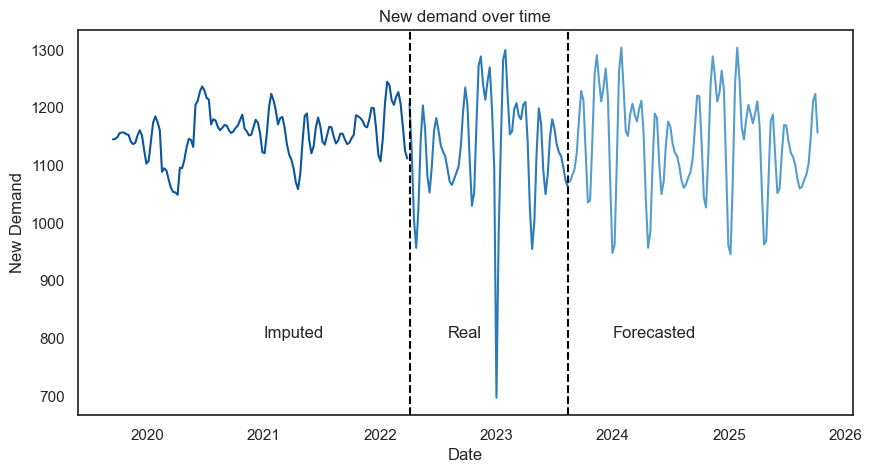

In [12]:
# Plot new demand on a timeseries graph
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(df_forecast_expanded, x='date', y='new_demand_imputed', hue='source_of_new_demand', legend=False)
ax.set(title='New demand over time', xlabel='Date', ylabel='New Demand')
plt.axvline(pd.to_datetime(df_forecast_expanded_real['date'].min()), color='black', linestyle='--')
plt.axvline(pd.to_datetime(df_forecast_expanded_real['date'].max()), color='black', linestyle='--')
plt.annotate(text='Imputed', xy=(pd.to_datetime('2021-01-01'),800))
plt.annotate(text='Real', xy=(pd.to_datetime('2022-08-01'),800))
plt.annotate(text='Forecasted', xy=(pd.to_datetime('2024-01-01'),800));

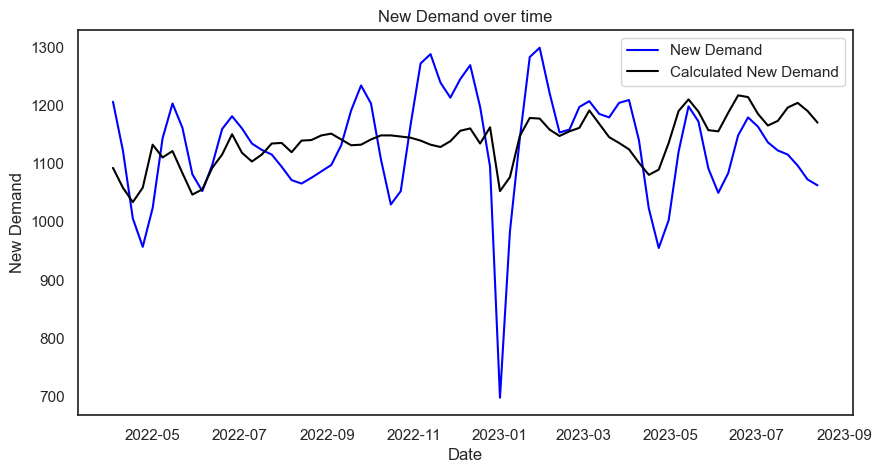

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
timeseries_plot(
    df_forecast_expanded_real, 'date', 'Date', 'new_demand', 'New Demand', 
    existing_ax=ax)
timeseries_plot(
    df_forecast_expanded_real, 'date', 'Date', 'calculated_new_demand', 
    'New Demand', existing_ax=ax, target_var=True)

In [14]:
# Reset new demand as the calculated column and drop extra columns
df_forecast_expanded['new_demand'] = df_forecast_expanded['new_demand_imputed']
df_forecast_expanded = df_forecast_expanded.drop([
    'from_forecast_base',
    'change_in_waiting_list',
    'calculated_new_demand',
    'new_demand_imputed',
    ], axis = 1)

### Used model for `forecast_capacity.csv` to extend for all dates in `forecast_base.csv`

In [15]:
# Get all dates from df_forecast_base
df_forecast_capacity_future = df_forecast_base.copy()
df_forecast_capacity_future = \
    df_forecast_capacity_future[df_forecast_capacity_future['date']>=df_forecast_capacity['date'][0]].reset_index(drop=True)

In [16]:
df_forecast_capacity_future.columns = df_forecast_capacity.columns.tolist()[0:2]
# Add in column for capacity
df_forecast_capacity_future['capacity'] = df_forecast_capacity.loc[0,'capacity']
df_forecast_capacity_future['activity_%_of_capacity_(90%)'] = round((df_forecast_capacity_future['capacity']*0.9)).astype(int)
# Calculate the remaining columns
initial_backlog = 4500
df_forecast_capacity_future['in_week_unmet_demand'] = \
    (df_forecast_capacity_future['new_demand'] - \
        df_forecast_capacity_future['activity_%_of_capacity_(90%)'])
initial_unmet_demand = df_forecast_capacity_future.at[0,'in_week_unmet_demand']
df_forecast_capacity_future['cumulative_unmet_demand'] = \
    df_forecast_capacity_future['in_week_unmet_demand'].cumsum()
df_forecast_capacity_future['backlog'] = \
    (initial_backlog - initial_unmet_demand + \
        df_forecast_capacity_future['cumulative_unmet_demand'].cumsum())
df_forecast_capacity_future['backlog_change'] = \
    df_forecast_capacity_future['backlog'].diff().fillna(0).astype(int)
df_forecast_capacity_future['cumulative_backlog_change'] = \
    (df_forecast_capacity_future['backlog_change'].cumsum())
df_forecast_capacity_future['percentage_increase'] = \
    (df_forecast_capacity_future['backlog'] - initial_backlog) / initial_backlog

### Write to csv

In [17]:
df_forecast_expanded.to_csv(f'../05.output/forecast_expanded_imputed.csv')
df_forecast_capacity_future.to_csv(f'../05.output/forecast_capacity_future.csv')